In [0]:
# pip install apache-airflow-providers-papermill

In [0]:
from pyspark.sql.functions import date_format, col, sum, round, when
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
df_kaggle = spark.read.csv('/FileStore/tables/kaggle-1.csv', header=True)

In [0]:
df_vendas = df_kaggle.withColumn("created_at", date_format("created_at", "yyyy-MM-dd HH:mm:ss"))
df_vendas = df_vendas.withColumn("updated_at", date_format("updated_at", "yyyy-MM-dd HH:mm:ss"))
df_vendas = df_vendas.withColumn("price_y", col("price_y").cast("float"))
df_vendas = df_vendas.withColumn("price_x", col("price_x").cast("float"))   
df_vendas = df_vendas.withColumn("ano", date_format("created_at", "yyyy"))                          

In [0]:
df_total_transacao = df_vendas.groupBy("sale_id").agg(sum(col("price_x")).alias("valor_total_transacao"))
df_total_transacao = df_total_transacao.withColumn("valor_total_transacao", round(col("valor_total_transacao"), 2))

df_total_produto = df_vendas.groupBy("product_id").agg(sum(col("price_x")).alias("valor_total_produto"))
df_total_produto = df_total_produto.withColumn("valor_total_produto", round(col("valor_total_produto"), 2))

In [0]:
df_vendas_kaggle = df_vendas.join(df_total_transacao, (df_total_transacao.sale_id == df_vendas.sale_id), how='left')\
                            .join(df_total_produto, (df_total_produto.product_id == df_vendas.product_id), how='left')\
                            .drop(df_total_transacao.sale_id)\
                            .drop(df_total_produto.product_id)

In [0]:
# Criando categorias personalizadas com base no valor de venda
df_vendas_kaggle = df_vendas_kaggle.withColumn("categoria", when(col("price_x") > 1000, "Categoria Premium")
                                   .when((col("price_x") > 500) & (col("price_x") <= 1000), "Categoria Intermediária")
                                   .otherwise("Categoria Básica"))

In [0]:
# Calculando a soma total de vendas por ano
df_vendas_ano = df_vendas.groupBy("ano").agg(sum(col("price_x")).alias("total_vendas_ano"))
df_vendas_ano = df_vendas_ano.withColumn("total_vendas_ano", round(col("total_vendas_ano"), 2))

In [0]:
df_vendas_kaggle.write.parquet("/FileStore/tables/vendas_kaggle.parquet")
df_vendas_kaggle.write.format("delta").mode("overwrite").save("/FileStore/tables/vendas_kaggle")

df_vendas_ano.write.parquet("/FileStore/tables/vendas_ano.parquet")
df_vendas_ano.write.format("delta").mode("overwrite").save("/FileStore/tables/vendas_ano")

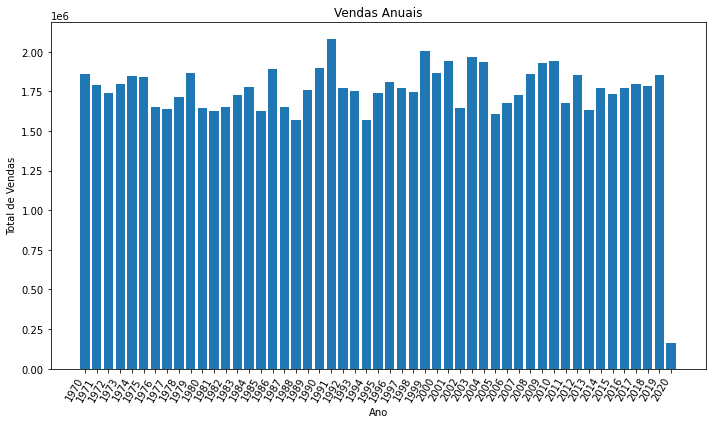

In [0]:
# Visualização: Gráfico de barras para vendas mensais
df_vendas_ano = df_vendas_ano.orderBy("ano")
vendas_ano_pd = df_vendas_ano.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(vendas_ano_pd['ano'], vendas_ano_pd['total_vendas_ano'])
plt.title('Vendas Anuais')
plt.xlabel('Ano')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

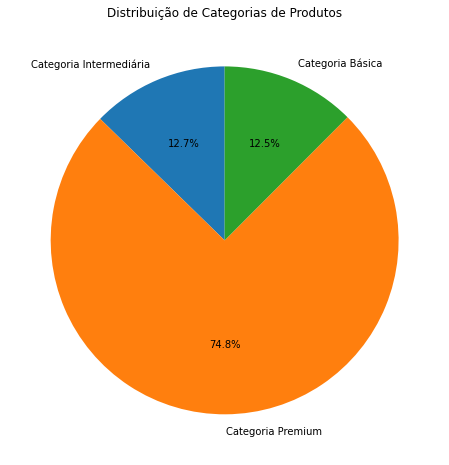

In [0]:
# Visualização: Gráfico de pizza para categorias de produtos
qtde_categoria = df_vendas_kaggle.groupBy("categoria").count().toPandas()
plt.figure(figsize=(8, 8))
plt.pie(qtde_categoria['count'], labels=qtde_categoria['categoria'], autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Categorias de Produtos')
plt.show()

## Criação do Ariflow para agendamento do Notebook

In [0]:
from airflow import DAG
from airflow.operators.papermill_operator import PapermillOperator
from datetime import datetime, timedelta

dag_name = 'atualiza_vendas_kaggle'

# Configuração padrão para o DAG
default_args = {
    'owner': 'Leonardo Andrade',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 21),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    dag_name,
    default_args=default_args,
    description='DAG para atualização automática dos dados das vendas do Kaggle',
    # schedule_interval='*/30 * * * *',
    schedule_interval='@daily',
)

notebook_path = '/Users/landrade.investimentos@hotmail.com/Entrevistas/ntb_agronegocio.ipynb'

execute_notebook = PapermillOperator(
    task_id='execute_notebook',
    input_nb=notebook_path,
    output_nb=notebook_path,
    dag=dag,
)

execute_notebook

if __name__ == "__main__":
    dag.cli()